### Neural Network - Physics
Our goal in this notebook is to learn how to use Tensorflow Keras and neural networks by using it to model a basic physics equation. The physics equation to be used is that of kinetic energy: `1/2 mv^2`

Why do this?
- The physics equation is well known already, so we don't have to worry about error functions for now and can focus solely on neural networks and their performance.
- The physics equation is simple with few moving parts/variables, therefore we'll be using a simple neural network too.
- There is a given equation, which can be used to generate our data. This simplifies our data gathering process and we won't have to worry about errors due to noise or measurement in our data.
- Since we only have a simple model we're trying to create, we can also experiment on the number of layers used, the number of nodes for each of those layers, the activation functions to use for those layers, and the type of network structure to use. We can then compare and see which combinations work better than others for this particular problem.

Now that we get that out of the way, let's get to creating neural networks!

In [1]:
import numpy as np

# Here's our simple physics equation!
def GetOutput(m, v):
    return 0.5 * m * v**2

trainSize = 7000
testSize = 3000
dataSize = trainSize + testSize
inputs = []
outputs = []
mMin = 1
mMax = 50
vMin = 1
vMax = 25
for i in range(dataSize):
    m = np.random.uniform(mMin, mMax)
    v = np.random.uniform(vMin, vMax)
    ek = GetOutput(m, v)
    inputs.append([m, v])
    outputs.append([ek])
    
inputs = np.asarray(inputs)
outputs = np.asarray(outputs)

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

class CustomCallback(keras.callbacks.Callback):
    def __init__(self):
        super(CustomCallback, self).__init__()
        self.massHistory = {}
        self.velocityHistory = {}
    
    def on_epoch_end(self, epoch, logs=None):
        mVals = np.arange(mMin, mMax)
        vVals = np.arange(vMin, vMax)
        mConst = (mMax + mMin) / 2
        vConst = (vMax + vMin) / 2
        
        for m in mVals:
            i = np.array([[m, vConst]])

            prediction = outputScaler.inverse_transform(self.model.predict(inputScaler.transform(i)))[0, 0]
            actual = GetOutput(m, vConst)
            if m in self.massHistory:
                self.massHistory[m].append([prediction, actual])
            else:
                self.massHistory[m] = [[prediction, actual]]
            
        for v in vVals:
            i = np.array([[mConst, v]])

            prediction = outputScaler.inverse_transform(self.model.predict(inputScaler.transform(i)))[0, 0]
            actual = GetOutput(mConst, v)
            if v in self.velocityHistory:
                self.velocityHistory[v].append([prediction, actual])
            else:
                self.velocityHistory[v] = [[prediction, actual]]

In [3]:
inputScaler = StandardScaler()
inputScaler.fit(inputs)
inputs = inputScaler.transform(inputs)

outputScaler = StandardScaler()
outputScaler.fit(outputs)
outputs = outputScaler.transform(outputs)[:, 0]

trainInputs = inputs[:trainSize]
trainOutputs = outputs[:trainSize]
testInputs = inputs[trainSize:]
testOutputs = outputs[trainSize:]

# Defining the model, 2 hidden layers with relu activation and 1 output layer
model = Sequential()
model.add(Dense(8, input_dim=2, kernel_initializer='he_uniform', activation="relu"))
model.add(Dense(4, activation="relu"))
model.add(Dense(1, activation="linear"))

opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss="mse", optimizer=opt)

callback = CustomCallback()
history = model.fit(trainInputs, trainOutputs, validation_data=(testInputs, testOutputs), epochs=100, verbose=0, callbacks=[callback])
trainMSE = model.evaluate(trainInputs, trainOutputs, verbose=0)
testMSE = model.evaluate(testInputs, testOutputs, verbose=0)

print("Train:", trainMSE, ", Test:", testMSE)

Train: 0.003149505704641342 , Test: 0.003082514740526676


In [4]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams
from cycler import cycler

matplotlib.style.use("dark_background")
%matplotlib inline
rcParams["figure.figsize"] = (15, 6)
rcParams["axes.prop_cycle"] = cycler(color=["#4299E1", "#F56565", "#48BB78", "#ED8936", "#9F7AEA", "#ECC94B"])
rcParams["figure.facecolor"] = "#1A202C"
rcParams["axes.facecolor"] = "#2D3748"
rcParams["axes.edgecolor"] = "#A0AEC0"
rcParams["axes.grid"] = True
rcParams["grid.color"] = "#A0AEC0"
rcParams["grid.alpha"] = 0.7
rcParams["axes.titlecolor"] = "#A0AEC0"
rcParams["axes.labelcolor"] = "#A0AEC0"
rcParams["xtick.color"] = "#A0AEC0"
rcParams["ytick.color"] = "#A0AEC0"

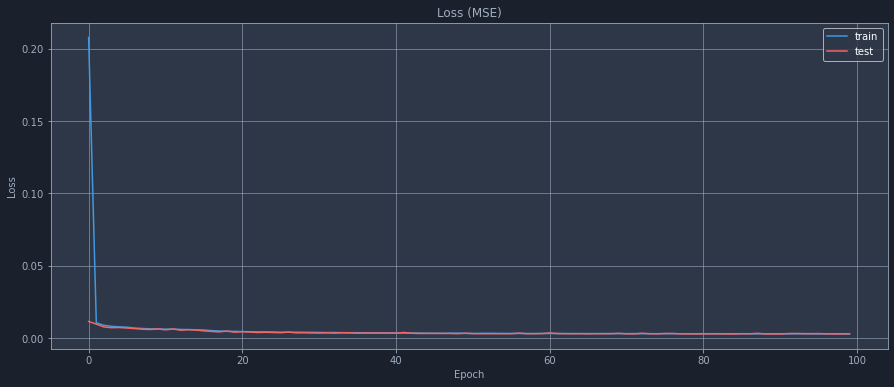

In [5]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss (MSE)")
plt.show()

In [6]:
m = 20
v = 16

i = np.array([[m, v]])

prediction = outputScaler.inverse_transform(model.predict(inputScaler.transform(i)))[0, 0]
actual = GetOutput(m, v)
print("Prediction: ", prediction, "\nActual:", actual, "\nRelative Error:", abs(actual - prediction) / actual)

Prediction:  2596.1082 
Actual: 2560.0 
Relative Error: 0.014104747772216797


In [7]:
# Plot the value of kinetic energy given a mass of 20 and velocity of 16 over time
# Compare this with the true value of kinetic energy

def getMassDiff(epoch, mass):
    arr = callback.massHistory[mass][epoch]
    return abs(arr[1] - arr[0]) / arr[1]

def getVelocityDiff(epoch, velocity):
    arr = callback.velocityHistory[velocity][epoch]
    return abs(arr[1] - arr[0]) / arr[1]

epochs = np.arange(0, 100)

masses = np.arange(mMin, mMax)
xMass, yMass = np.meshgrid(epochs, masses)
zMass = []
for y in masses:
    arr = []
    for x in epochs:
        arr.append(getMassDiff(x, y))
    zMass.append(arr)
zMass = np.array(zMass)

velocities = np.arange(vMin, vMax)
xVel, yVel = np.meshgrid(epochs, velocities)
zVel = []
for y in velocities:
    arr = []
    for x in epochs:
        arr.append(getVelocityDiff(x, y))
    zVel.append(arr)
zVel = np.array(zVel)


# Latest epoch, plot how much result diff depending on mass and velocity
def getCurrentDiff(m, v):
    i = np.array([[m, v]])
    prediction = outputScaler.inverse_transform(model.predict(inputScaler.transform(i)))[0, 0]
    actual = GetOutput(m, v)
    return min(abs(actual - prediction) / actual, 1)

zMassVel = []
for v in velocities:
    arr = []
    for m in masses:
        arr.append(getCurrentDiff(m, v))
    zMassVel.append(arr)
zMassVel = np.array(zMassVel)

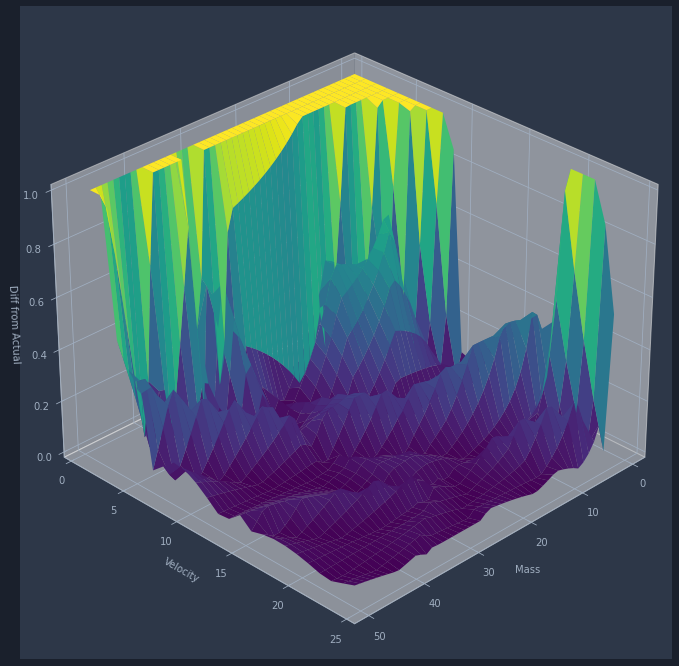

In [8]:
xMassVel, yMassVel = np.meshgrid(masses, velocities)
fig = plt.figure(figsize=(20, 12))
massVelAx = fig.add_subplot(111, projection="3d")
massVelAx.plot_surface(xMassVel, yMassVel, zMassVel, cmap="viridis")
massVelAx.set_xlabel("Mass")
massVelAx.set_ylabel("Velocity")
massVelAx.set_zlabel("Diff from Actual")
massVelAx.set_zlim(0, 1)
massVelAx.view_init(30, 45)

Near the low extremities of mass and velocity, the model can't interpolate well. Let's see the distribution of our training data:

C:\Users\markm\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

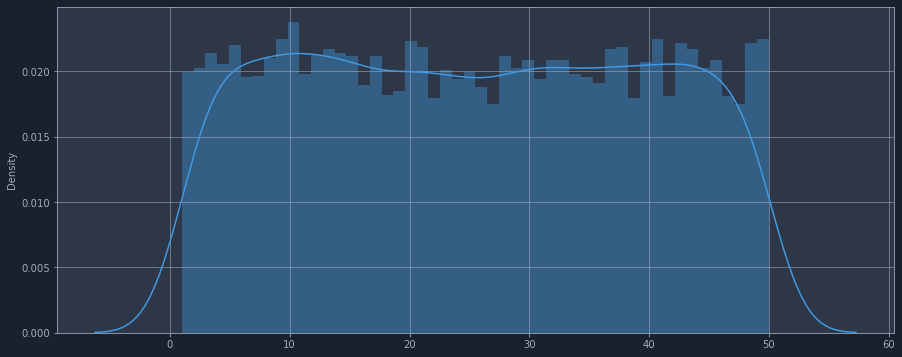

In [9]:
import seaborn as sns

newInputs = np.array(inputScaler.inverse_transform(trainInputs))
massVals = newInputs[:, 0]
velVals = newInputs[:, 1]

sns.distplot(massVals, bins=(mMax - mMin + 1))

C:\Users\markm\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

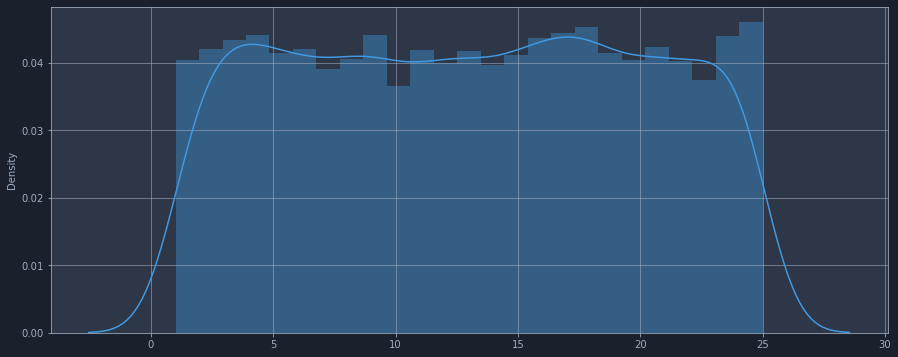

In [10]:
sns.distplot(velVals, bins=(vMax - vMin + 1))

### Neural Networks
#### Pros:
- Quickly improves over time
- Good at interpolating values based on data given
- Easy to scale up the neural network if needed (add more nodes and layers)

#### Cons:
- Past data needs to be representative of the future (meaning the future values don't deviate too much from the past values)
- Does not extrapolate well (it fails when given values outside of its training data)
- Need lots of data to work well
- Difficult to interpret/explain why the neural network did what it did or how the neural network arrived to certain values